# First exploration to get an understanding of the data
Explore the functions in buildDataset and views the data. 

In [20]:
import numpy as np
import os
import glob
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import dataset
import pickle
from sklearn.utils import resample
from skimage import exposure
import cv2
import math

DATAPATHS = {
    "preprocessed": r'C:\Users\line\Desktop\Mauro\preprocessing\preprocessed_octs',
    "rootsavepath": r'C:\Users\line\Desktop\Mauro\3_DataSet\Vectors' ,
}

In [2]:


def getXYdata(paths, mode,rootpath = None,normmode = 'Z-score'):
    def normalize(img,normmode = 'Z-score'):
        if normmode == 'Z-score':
            img = dataset.z_score(img)
        elif normmode == 'EQ-hist': 
            img = exposure.equalize_hist(img)
        elif normmode == 'CLAHE':
            #TO Implement normalization by zone
            # Adaptive Equalization
            img = exposure.equalize_adapthist(img/max((img.max(),-img.min())), clip_limit=0.03)            
        return img
    
    def getxmin(rootpath):
        themin = 100000
        allpaths =  paths
        for path in paths:
            PPocts = pd.read_pickle(path)
            for PPoct in PPocts:
                xnew = PPoct.image()
                if(xnew.shape[0] < themin):
                    themin = xnew.shape[0]
        return themin
    
    if mode == 'thickness':
        xmin = 5 
    elif mode =='raw':
        xmin = getxmin(rootpath)
        
    X = np.empty((0,xmin))
    y = np.empty((0,))
    for i, path in enumerate(paths):
        print("path number:", i+1)
        PPocts = pd.read_pickle(path)

        print("Length of PPocts:", len(PPocts)) 
    
        for PPoct in PPocts:

            if mode == 'thickness':
                xnew = np.transpose(PPoct.thicknesses())
            elif mode == 'raw':
                xnew = np.transpose(normalize(PPoct.image(),normmode = normmode))
                xnew = cv2.resize(xnew, dsize=(xmin,768 ))
            ynew = PPoct.label()
            #stack vertically the x and y
            X = np.vstack((X,xnew))
            y = np.hstack((y,ynew))

    print("length of paths: ", len(paths))      
    print("shape of xnew:", xnew.shape)    
            

    print("image:", PPoct.image())
    plt.imshow(PPoct.image())
    print("label:", PPoct.label())
    print("thickness:", PPoct.thicknesses())

    

    return X,y
    
def getBalancedXYData(mode = 'thickness',normmode = 'EQ-hist', patient = 'both'):
    """
    return data X (processed OCT arrays) and y (labels)
    - mode: 
    - normmode: 
    - patient: set to 'control', 'amd' or both. By default, set to 'both'. Select from which type of patient, control, amd or both, the OCT should come from.
    """
    rootpath = r'C:\Users\line\Desktop\Mauro\3_DataSet\OCT_balanced'

    if patient == 'both':   
        paths = glob.glob(os.path.join(rootpath,'controlP' + '\*.pickle'))
        paths2 = glob.glob(os.path.join(rootpath,'amdP' + '\*.pickle'))
        merged = [[paths[2*i],paths[2*i+1],paths2[i]]  for i in range(len(paths2))]
        paths = [item for sublist in merged for item in sublist]

    elif patient == 'control':
        paths = glob.glob(os.path.join(rootpath,'controlP' + '\*.pickle'))

    elif patient == 'amd':
        paths = glob.glob(os.path.join(rootpath,'amdP' + '\*.pickle'))
        
    else: 
        print('Warning: argument patient was wrongly set. Thus patient is set to "both".')
        paths = glob.glob(os.path.join(rootpath,'controlP' + '\*.pickle'))
        paths2 = glob.glob(os.path.join(rootpath,'amdP' + '\*.pickle'))
        merged = [[paths[2*i],paths[2*i+1],paths2[i]]  for i in range(len(paths2))]
        paths = [item for sublist in merged for item in sublist]
        
    print(paths)
    return getXYdata(paths, mode = mode,rootpath = rootpath,normmode = normmode)

['C:\\Users\\line\\Desktop\\Mauro\\3_DataSet\\OCT_balanced\\controlP\\0.pickle', 'C:\\Users\\line\\Desktop\\Mauro\\3_DataSet\\OCT_balanced\\controlP\\10.pickle', 'C:\\Users\\line\\Desktop\\Mauro\\3_DataSet\\OCT_balanced\\amdP\\0.pickle', 'C:\\Users\\line\\Desktop\\Mauro\\3_DataSet\\OCT_balanced\\controlP\\11.pickle', 'C:\\Users\\line\\Desktop\\Mauro\\3_DataSet\\OCT_balanced\\controlP\\12.pickle', 'C:\\Users\\line\\Desktop\\Mauro\\3_DataSet\\OCT_balanced\\amdP\\1.pickle', 'C:\\Users\\line\\Desktop\\Mauro\\3_DataSet\\OCT_balanced\\controlP\\2.pickle', 'C:\\Users\\line\\Desktop\\Mauro\\3_DataSet\\OCT_balanced\\controlP\\3.pickle', 'C:\\Users\\line\\Desktop\\Mauro\\3_DataSet\\OCT_balanced\\amdP\\2.pickle', 'C:\\Users\\line\\Desktop\\Mauro\\3_DataSet\\OCT_balanced\\controlP\\4.pickle', 'C:\\Users\\line\\Desktop\\Mauro\\3_DataSet\\OCT_balanced\\controlP\\5.pickle', 'C:\\Users\\line\\Desktop\\Mauro\\3_DataSet\\OCT_balanced\\amdP\\3.pickle', 'C:\\Users\\line\\Desktop\\Mauro\\3_DataSet\\OCT_bal

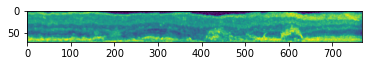

In [3]:
X,y = getBalancedXYData(mode = 'raw',normmode = 'EQ-hist', patient = '')
print(X.shape)
print(y.shape)

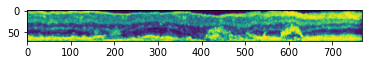

In [4]:
plt.imshow(X[-768:,:].transpose()) # one image of OCT scan looks like this
# print(y[-768:]) # the labels attributed to the vertical vector

# Exploration of model performance with edge enhancing filter

In [5]:
from buildDataset import *
%matplotlib inline
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
root_path =      DATAPATHS["preprocessed"]
from sklearn.model_selection import KFold

from sklearn.metrics import PrecisionRecallDisplay

# for data augmentation
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [6]:
def score_model_PR(model, X, y, params = None, cv=None, seq_X = None, seq_y = None, N_iter = 3, plotMatrix = None, plotROC = None, setTreshold = None, ax2 = None, modelname = '', label = None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    Input:
    - X OCT scans, np.array of shape (193536, 70)
    - y label, np.array of shape (193536,) 
    - N_iter: number of iterations augmentated data is added
    - seq_X: iaa.Sequential, applied on X. 
    - seq_y: iaa.Sequential, applied on y. Should correspond to seq_X.
    """
    #smoter = SMOTE(random_state=42)
    
    scores = []
    y_real = []
    y_proba = []
    
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for fold, (train_fold_index, val_fold_index) in enumerate(cv.split(X, y)):
        # Get the training data
        X_train_fold, y_train_fold = X[train_fold_index], y[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X[val_fold_index], y[val_fold_index]

        # Data augmentation: need to reshape to apply transformation per images.
        X_train_fold = X_train_fold.reshape((-1, 768, 70, 1))
        y_train_fold = y_train_fold.reshape((-1, 768, 1))
        X_train_aug = X_train_fold.copy()
        y_train_aug = y_train_fold.copy()

        if seq_X and seq_y:
            # add augmented data N_iter number of times.
            for _ in range(N_iter):
                X_aug_new = seq_X(images = X_train_fold)
                X_train_aug = np.append(X_train_aug, X_aug_new, axis = 0)

                segmap = np.zeros(X_aug_new.shape[:3], dtype = np.uint8)
                segmap[:,:,:] = y_train_fold
                segmap = SegmentationMapsOnImage(segmap, shape = X_train_fold.shape[:3])
                y_aug_new = seq_y(images = segmap.get_arr().astype(np.uint8))[:, :, 0].reshape((-1, 768, 1))
                y_train_aug = np.append(y_train_aug, y_aug_new, axis = 0)
                

        # Upsample only the data in the training section

        X_train_aug = X_train_aug.reshape((-1, 70))
        y_train_aug = y_train_aug.reshape((-1,))
        X_train_fold_upsample, y_train_fold_upsample = upsample(X_train_aug,y_train_aug)

        # Fit the model on the upsampled training data
        if params:
            model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
        else:
            model_obj = model().fit(X_train_fold_upsample, y_train_fold_upsample)
        pred_proba = model_obj.predict_proba(X_val_fold)
        y_real.append(y_val_fold)
        preds = pred_proba[:,1]
        y_proba.append(preds)
        if(plotMatrix):
            # Display confusion matrix
            ConfusionMatrixDisplay.from_estimator(model_obj, X_val_fold, y_val_fold)
            plt.show()
        if(plotROC):
            viz = PrecisionRecallDisplay.from_predictions(
                y_val_fold,
                preds,
                name=f"PR fold {fold}",
                alpha=0.3,
                lw=1,
                ax=ax,
            )

        if(setTreshold != None):
            predictions = (model_obj.predict_proba(X_val_fold)[:,1] >= setTreshold).astype(bool)
        # Score the model on the (non-upsampled) validation data
        else:
            predictions = model_obj.predict(X_val_fold)
        scores.append(recall_score(y_val_fold, predictions))
        scores.append(precision_score(y_val_fold, predictions))
        scores.append(accuracy_score(y_val_fold, predictions))
        scores.append(f1_score(y_val_fold, predictions))
    
    if seq_X:
        print("N_iter: ", N_iter)
        print("X train fold shape: ", X_train_fold.shape)
        print("X train aug shape: ", X_train_aug.shape) 

    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    if(plotROC):
        PrecisionRecallDisplay.from_predictions(
                    y_real,
                    y_proba,
                    name=f"PR AVG",
                    color="b",
                    lw=2,
                    alpha=0.8,
                    ax=ax,
                )
    if ax2:
        if label != None:
            PrecisionRecallDisplay.from_predictions(
                y_real,
                y_proba,
                name=f"{label}",
                lw=2,
                alpha=0.8,
                ax=ax2,
            )
        else:
            PrecisionRecallDisplay.from_predictions(
                y_real,
                y_proba,
                name=f"{str(list(params.items()))} {modelname}",
                lw=2,
                alpha=0.8,
                ax=ax2,
            )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="Precision",
        ylabel="Recall",
        title=f"Mean PR curve",
    )

    plt.show()

    return np.array(scores)

In [7]:
X,y = getBalancedXYData(mode = 'raw',normmode = 'EQ-hist')
print(X.shape)
print(y.shape)
print(768*14*18)

(193536, 70)
(193536,)
193536


In [8]:
X_float32 = X.astype('float32')
X_min = np.min(X_float32)
X_max = np.max(X_float32)
print("min of X: ", X_min)
print("max of X: ", X_max)

min of X:  0.0045237327
max of X:  1.0


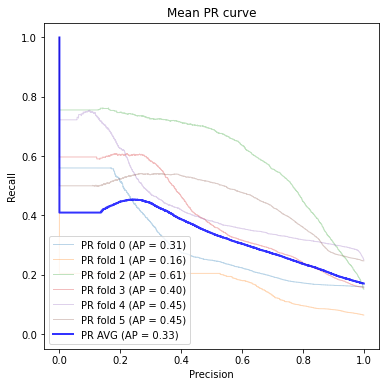

Here are the recall scores: [1. 1. 1. 1. 1. 1.]
Here are the precisions scores: [0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]
Here are the accuracies scores: [0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]
Here are the f1 scores: [0.27369548 0.11671289 0.26047565 0.27156789 0.39558308 0.39566288]


In [9]:
# model performance without filter
kf = KFold(n_splits=6, shuffle=False)

model = GaussianNB
scores = score_model_PR(model, X_float32, y, params = None, cv=kf, seq_X = None, seq_y = None, plotMatrix = False, plotROC = True, setTreshold = False)
print(f'Here are the recall scores: {scores[::4]}')
print(f'Here are the precisions scores: {scores[1::4]}')
print(f'Here are the accuracies scores: {scores[2::4]}')
print(f'Here are the f1 scores: {scores[3::4]}')

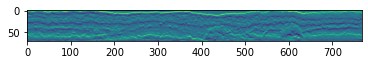

In [10]:
from scipy import ndimage as ndi

# applying the sobel filter on X:
X_sobel = ndi.sobel(X_float32, 1)
plt.imshow(X_sobel[-768:,:].transpose())

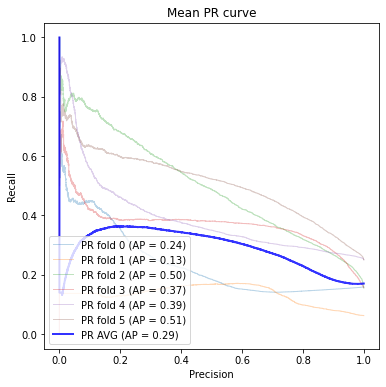

Here are the recall scores: [1. 1. 1. 1. 1. 1.]
Here are the precisions scores: [0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]
Here are the accuracies scores: [0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]
Here are the f1 scores: [0.27369548 0.11671289 0.26047565 0.27156789 0.39558308 0.39566288]


In [11]:
# model performance on sobel filtered images:
kf = KFold(n_splits=6, shuffle=False)

model = GaussianNB
scores = score_model_PR(model, X_sobel, y, params = None, cv=kf, seq_X = None, seq_y = None, plotMatrix = False, plotROC = True, setTreshold = False)
print(f'Here are the recall scores: {scores[::4]}')
print(f'Here are the precisions scores: {scores[1::4]}')
print(f'Here are the accuracies scores: {scores[2::4]}')
print(f'Here are the f1 scores: {scores[3::4]}')

## flattening OCT (for extra data)

In [16]:
import os
import glob
import preprocessing
import numpy as np
import pandas as pd

path = r'C:\Users\line\Desktop\Mauro\3_DataSet\ExternalOCTs\OCT2017\used\train\NORMAL'
root_config = 'C:\\Users\\line\\Desktop\\Mauro\\2_Preprocessing_Code\\config'
output_config = os.path.join(root_config, 'output.txt')



print('Parsing preprocessing config')
output_folders = preprocessing.parse_config_file(output_config)
print(output_folders['labelled_octs'])


Parsing preprocessing config
C:\Users\line\Desktop\Mauro\preprocessing\labelled_octs


In [17]:
def getData(paths, mode, rootpath = None, normmode = 'Z-score'):
    def normalize(img,normmode = 'Z-score'):
        if normmode == 'Z-score':
            img = dataset.z_score(img)
        elif normmode == 'EQ-hist': 
            img = exposure.equalize_hist(img)
        elif normmode == 'CLAHE':
            #TO Implement normalization by zone
            # Adaptive Equalization
            img = exposure.equalize_adapthist(img/max((img.max(),-img.min())), clip_limit=0.03)            
        return img
    
    def getxmin(rootpath):
        themin = 100000
        allpaths =  paths
        for path in paths:
            PPocts = pd.read_pickle(path)
            for PPoct in PPocts:
                xnew = PPoct.image()
                if(xnew.shape[0] < themin):
                    themin = xnew.shape[0]
        return themin
    
    if mode == 'thickness':
        xmin = 5 
    elif mode =='raw':
        xmin = getxmin(rootpath)
        
    X = np.empty((0,xmin))
    for path in paths:
        PPocts = pd.read_pickle(path)
        for PPoct in PPocts:
            if mode == 'thickness':
                xnew = np.transpose(PPoct.thicknesses())
            elif mode == 'raw':
                xnew = np.transpose(normalize(PPoct.image(),normmode = normmode))
                xnew = cv2.resize(xnew, dsize=(xmin,768 ))
            X = np.vstack((X,xnew))
      
    return X

def getLabelledData(mode = 'thickness', normmode = 'EQ-hist'):
    rootpath = r'C:\Users\line\Desktop\Mauro\5_Thickness\labelled_octs'
    paths = glob.glob(os.path.join(rootpath,'control' + '\*.pickle'))
    paths2 = glob.glob(os.path.join(rootpath,'amd' + '\*.pickle'))
    merged = [[paths[2*i],paths[2*i+1],paths2[i]]  for i in range(len(paths2))] # 2 control for 1 amd
    flattenedmerged = [item for sublist in merged for item in sublist]
    return getData(paths = flattenedmerged, mode = mode, rootpath = rootpath, normmode = normmode)


In [18]:
X = getLabelledData()
print(X.shape)

AttributeError: 'LabelledOCTScan' object has no attribute 'thicknesses'

In [13]:
print(X)

[]


In [24]:
from buildDataset import *
X,y = getBalancedXYData(mode = 'thickness',normmode = 'EQ-hist')

In [25]:
print(X.shape)

(193536, 5)


In [27]:
print(X[-768:,:])

[[ 5. 22. 16.  9. 15.]
 [ 5. 22. 16.  9. 15.]
 [ 5. 22. 16.  9. 15.]
 ...
 [15. 10. 12. 14. 13.]
 [15. 10. 12. 14. 13.]
 [15. 10. 12. 14. 13.]]


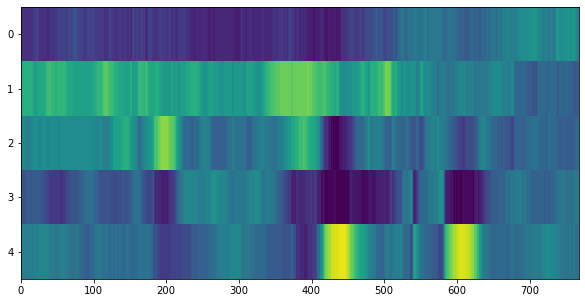

In [32]:
fig = plt.figure(figsize=(10,5))
plt.imshow(X[-768:,:].transpose(), aspect='auto', interpolation='nearest') 